## **Tasks**

# **Lab Assignment 2 - Principal Component Analysis (PCA) and Neural Networks**

Go through each link provided and implement the tasks below. 

Make a short report (pdf format) that includes: (1) plots/diagrams generated during training and evaluation, (2) key console output such as model summaries and training logs (loss/accuracy per epoch). Since the labs are only graded Pass/Fail, the report can be very simple, just copy and paste your results and figures given when running your program.

Upload your code as .py file/s.

During the scheduled lab sessions, present your code and report to a teacher. The focus should be on your observations, interpreting the results (what changed, why it matters). 


### **Principal Component Analysis (PCA)**

1. Load or create a dataset with more than 2 dimensions.

2. Find the first 2 principal components **with and without using sklearn**.

3. Practice using PCA to preserve a certain percentage of variance.

4. Train a classification or regression neural network by using:
   - a) The original dataset  
   - b) Principal components

5. Repeat part 4 using **Kernel PCA** (linear, sigmoid, RBF).

6. Build a pipeline to tune the hyperparameters of Kernel PCA and also the neural network.  
   **Questions:** Which hyperparameters can be tuned?

---

**Reference / Sample Code:**  
Hands-On Machine Learning 2nd Edition, Chapter 8, Dimensionality Reduction:  
[PCA and Dimensionality Reduction Notebook on GitHub](https://github.com/ageron/handson-ml2/blob/master/08_dimensionality_reduction.ipynb)


In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### **1. Load or create a dataset with more than 2 dimensions.**

**PCA**: Let's build a simple 3D dataset:

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

#### **2. Find the first 2 principal components with and without using sklearn**.

In [4]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

np.allclose(X_centered, U.dot(S).dot(Vt))

True

#### **Projecting Down to d Dimensions**

In [5]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

X2D_using_svd = X2D

#### **Using Scikit-Learn**
With Scikit-Learn, PCA is really trivial. It even takes care of mean centering for you:

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

X2D[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [ ]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

Notice that running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped. In this example, PCA using Scikit-Learn gives the same projection as the one given by the SVD approach, except both axes are flipped:

In [8]:
np.allclose(X2D, -X2D_using_svd)

False

Recover the 3D points projected on the plane (PCA 2D subspace).

In [9]:
X3D_inv = pca.inverse_transform(X2D)

Of course, there was some loss of information during the projection step, so the recovered 3D points are not exactly equal to the original 3D points:

In [10]:
np.allclose(X3D_inv, X)

False

We can compute the reconstruction error:

In [11]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

np.float64(0.01017033779284855)

In [12]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

The reconstructions from both methods are not identical because Scikit-Learn's PCA class automatically takes care of reversing the mean centering, but if we subtract the mean, we get the same reconstruction:

In [13]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

The PCA object gives access to the principal components that it computed:

In [14]:
pca.components_

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

Compare to the first two principal components computed using the SVD method:

In [15]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

Notice how the axes are flipped.

#### **3. Practice using PCA to preserve a certain percentage of variance.**

Now let's look at the explained variance ratio:

In [16]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

The first dimension explains 84.2% of the variance, while the second explains 14.6%.

By projecting down to 2D, we lost about 1.1% of the variance:

In [17]:
1 - pca.explained_variance_ratio_.sum()

np.float64(0.011195535570688975)

Here is how to compute the explained variance ratio using the SVD approach (recall that s is the diagonal of the matrix S):

In [18]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

#### **4. Train a classification or regression neural network by using:**

In [19]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [20]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [22]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

np.int64(154)

Saving figure explained_variance_plot


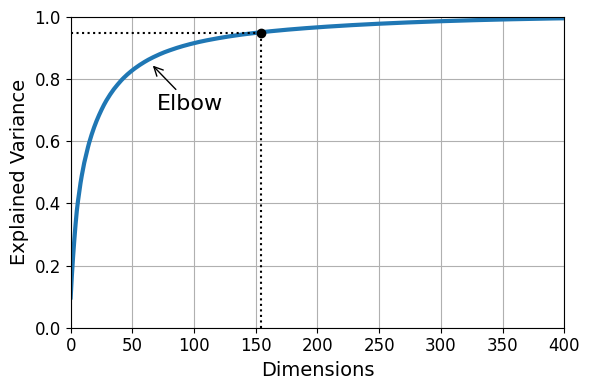

In [23]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

In [24]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_

np.int64(154)

In [25]:
np.sum(pca.explained_variance_ratio_)

np.float64(0.9503684424557437)

In [26]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [27]:
# EXTRA
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure mnist_compression_plot


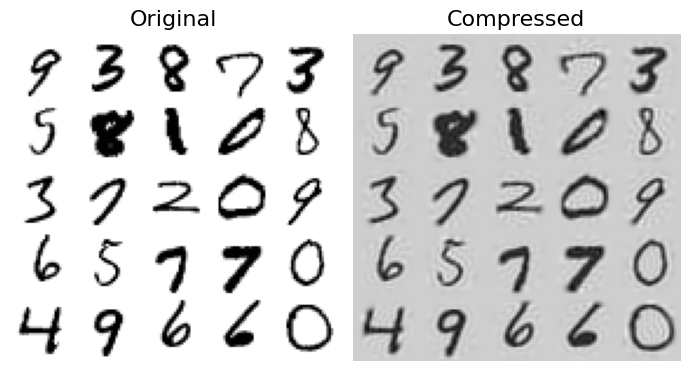

In [28]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

In [29]:
X_reduced_pca = X_reduced

In [30]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [31]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [32]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

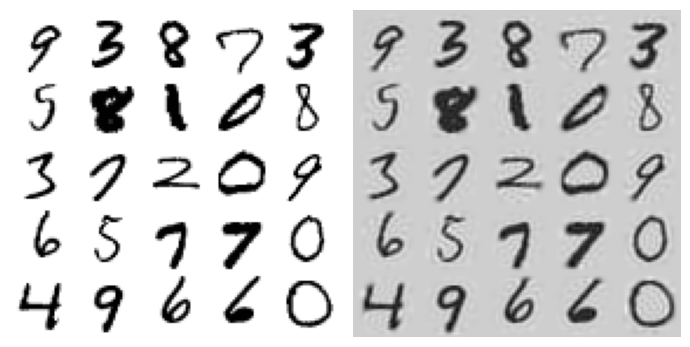

In [33]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [34]:
X_reduced_inc_pca = X_reduced

In [36]:
np.allclose(pca.mean_, inc_pca.mean_)

True

In [37]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

In [38]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [39]:
del X_mm

In [40]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

,n_components,154
,whiten,False
,copy,True
,batch_size,525


In [41]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components, svd_solver="full")
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for name, pca in (("PCA", regular_pca), ("Inc PCA", inc_pca), ("Rnd PCA", rnd_pca)):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(name, t2 - t1))

n_components = 2
    PCA: 4.4 seconds
    Inc PCA: 14.0 seconds
    Rnd PCA: 1.0 seconds
n_components = 10
    PCA: 3.7 seconds
    Inc PCA: 14.3 seconds
    Rnd PCA: 0.9 seconds
n_components = 154
    PCA: 4.0 seconds
    Inc PCA: 18.8 seconds
    Rnd PCA: 3.6 seconds


Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

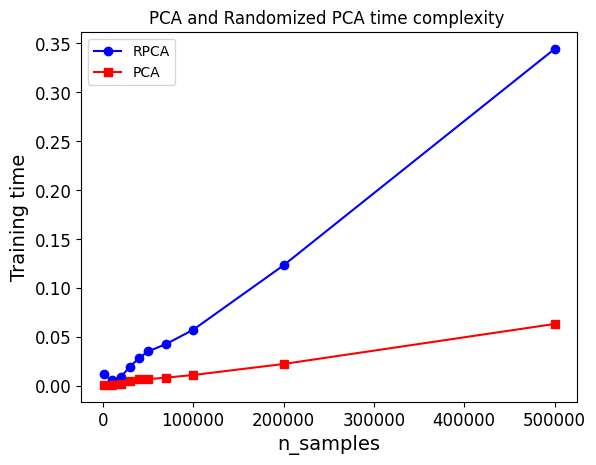

In [42]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

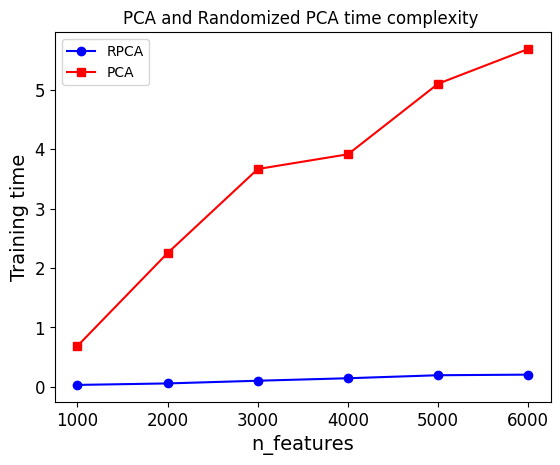

In [43]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components=2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

#### **5. Repeat part 4 using **Kernel PCA** (linear, sigmoid, RBF)**

In [45]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [46]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

Saving figure kernel_pca_plot


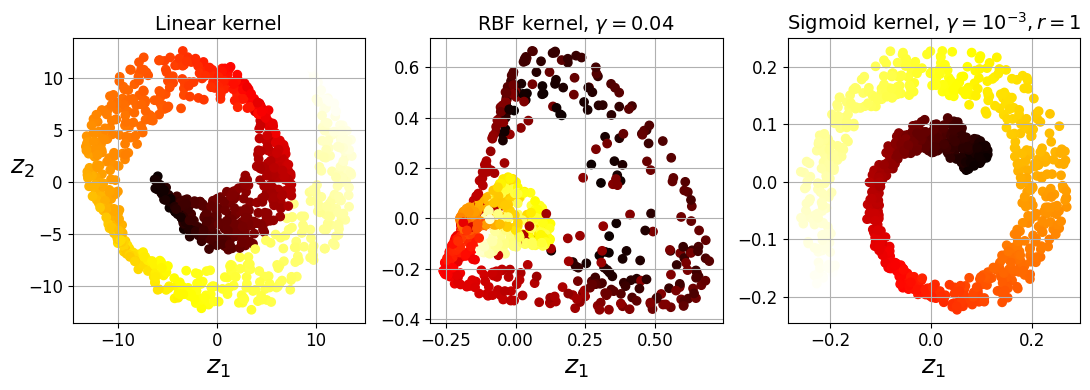

In [47]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

Saving figure preimage_plot


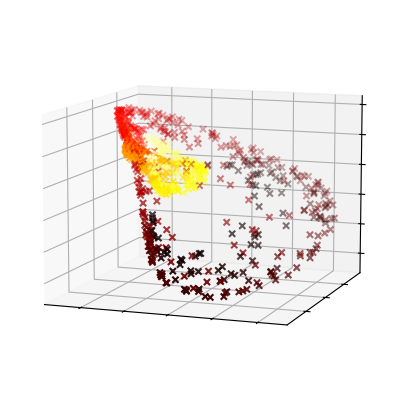

In [48]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

save_fig("preimage_plot", tight_layout=False)
plt.show()

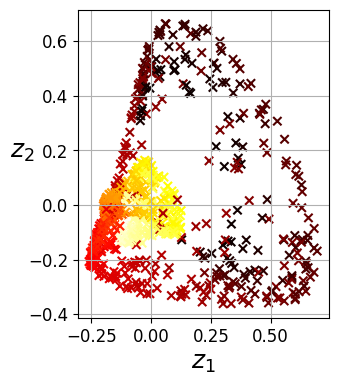

In [49]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

#### **6. Build a pipeline to tune the hyperparameters of Kernel PCA and also the neural network.**  

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

,estimator,Pipeline(step...egression())])
,param_grid,"[{'kpca__gamma': array([0.03 ..., 0.05 ]), 'kpca__kernel': ['rbf', 'sigmoid']}]"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_components,2


In [51]:
print(grid_search.best_params_)

{'kpca__gamma': np.float64(0.043333333333333335), 'kpca__kernel': 'rbf'}


In [52]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [53]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576612

**🔧 Kernel PCA — Common Hyperparameters and Their Meanings**

**1. kernel**

Specifies the type of kernel (similarity function) used in Kernel PCA.
Common options:

- rbf — radial basis (Gaussian) kernel

- poly — polynomial kernel

- sigmoid — sigmoid (tanh) kernel

- linear — standard linear PCA

- cosine — cosine similarity kernel

*Effect: Controls how the data is mapped into a higher-dimensional feature space.*

**2. gamma**

Used in RBF, polynomial, and sigmoid kernels.

*Defines how far the influence of a training point reaches.*

- Large gamma → tighter, more complex mapping (risk of overfitting)

- Small gamma → smoother, more global mapping (risk of underfitting)

**3. degree**

Used only with the polynomial kernel (poly).

*Controls the flexibility/complexity of the polynomial mapping.*

**4. coef0**

Used in polynomial (poly) and sigmoid kernels.

*Shifts the kernel function and affects nonlinearity.*

**5. n_components**

Number of principal components (embedding dimensions) to keep.

- Lower values → strong dimensionality reduction

- Higher values → retain more variance but risk overfitting downstream models

## Classification Problem Assignment

1. Load **IRIS** and **Fashion MNIST** datasets from Keras.  
2. Build and train a neural network to classify each of the loaded labeled datasets.  
3. Tune hyperparameters (e.g. number of hidden layers/units, activation functions). What else can you tune?  
4. Plot the loss and accuracy for both training and testing datasets.  
5. Save the weights of the model’s layers and use callbacks during training.  
6. Practice saving and loading the trained model.

---

**Reference / Sample Code:**  
Neural networks with Keras — classification & regression examples:  
[10_neural_nets_with_keras.ipynb on GitHub](https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb)


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ---------------- IRIS ----------------
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

scaler = StandardScaler()
X_iris = scaler.fit_transform(X_iris)

X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
    X_iris, y_iris, test_size=0.2, random_state=42
)

# ---------------- Fashion MNIST ----------------
(X_train_fmnist, y_train_fmnist), (X_test_fmnist, y_test_fmnist) = keras.datasets.fashion_mnist.load_data()

X_train_fmnist = X_train_fmnist.astype("float32") / 255.0
X_test_fmnist = X_test_fmnist.astype("float32") / 255.0

X_train_fmnist = X_train_fmnist.reshape(-1, 28*28)
X_test_fmnist = X_test_fmnist.reshape(-1, 28*28)


In [2]:
import keras_tuner as kt
from tensorflow import keras

def build_hypermodel(hp, input_dim, num_classes):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(input_dim,)))

    # Tune hidden layers
    for i in range(hp.Int("num_layers", 1, 4)):
        model.add(
            keras.layers.Dense(
                units=hp.Int(f"units_{i}", 32, 256, step=32),
                activation=hp.Choice("activation", ["relu", "tanh", "elu"])
            )
        )

        # Optional dropout
        if hp.Boolean(f"use_dropout_{i}"):
            model.add(keras.layers.Dropout(
                hp.Float(f"dropout_rate_{i}", 0.1, 0.5, step=0.1)
            ))

    # Output layer
    model.add(keras.layers.Dense(num_classes, activation="softmax"))

    # Tune optimizer LR
    lr = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
    optimizer = keras.optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [3]:
def iris_model_builder(hp):
    return build_hypermodel(hp, input_dim=4, num_classes=3)

tuner_iris = kt.RandomSearch(
    iris_model_builder,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="iris_tuner",
    project_name="iris_randomsearch",
    overwrite=True
)

# Perform search
tuner_iris.search(
    X_train_iris, y_train_iris,
    validation_data=(X_test_iris, y_test_iris),
    epochs=20,
    callbacks=[keras.callbacks.EarlyStopping(patience=3)]
)

best_hp_iris = tuner_iris.get_best_hyperparameters(1)[0]
best_model_iris = tuner_iris.get_best_models(1)[0]


Trial 10 Complete [00h 00m 03s]
val_accuracy: 0.9333333373069763

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 00m 31s


C:\Users\pablo\AppData\Roaming\Python\Python313\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [4]:
def fmnist_model_builder(hp):
    return build_hypermodel(hp, input_dim=784, num_classes=10)

tuner_fmnist = kt.RandomSearch(
    fmnist_model_builder,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="fmnist_tuner",
    project_name="fmnist_randomsearch",
    overwrite=True
)

# Perform search
tuner_fmnist.search(
    X_train_fmnist, y_train_fmnist,
    validation_split=0.2,
    epochs=10,
    callbacks=[keras.callbacks.EarlyStopping(patience=3)]
)

best_hp_fmnist = tuner_fmnist.get_best_hyperparameters(1)[0]
best_model_fmnist = tuner_fmnist.get_best_models(1)[0]


Trial 10 Complete [00h 00m 39s]
val_accuracy: 0.8433333039283752

Best val_accuracy So Far: 0.890666663646698
Total elapsed time: 00h 05m 53s


C:\Users\pablo\AppData\Roaming\Python\Python313\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [5]:
history_iris = best_model_iris.fit(
    X_train_iris, y_train_iris,
    validation_data=(X_test_iris, y_test_iris),
    epochs=30,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint("best_iris_model.keras", save_best_only=True),
    ]
)

history_fmnist = best_model_fmnist.fit(
    X_train_fmnist, y_train_fmnist,
    validation_data=(X_test_fmnist, y_test_fmnist),
    epochs=20,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint("best_fmnist_model.keras", save_best_only=True),
    ]
)


Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9583 - loss: 0.1126 - val_accuracy: 0.9667 - val_loss: 0.0909
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9583 - loss: 0.1358 - val_accuracy: 1.0000 - val_loss: 0.0597
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9500 - loss: 0.1085 - val_accuracy: 0.9667 - val_loss: 0.0712
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9500 - loss: 0.1078 - val_accuracy: 1.0000 - val_loss: 0.0576
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9583 - loss: 0.0924 - val_accuracy: 1.0000 - val_loss: 0.0505
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9833 - loss: 0.0781 - val_accuracy: 1.0000 - val_loss: 0.0480
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9750 - loss: 0.0700 - val_accuracy: 1.0000 - val_loss: 0.0375
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9750 - loss: 0.0751 - val_accuracy: 1.0000 - val_loss: 0.0303


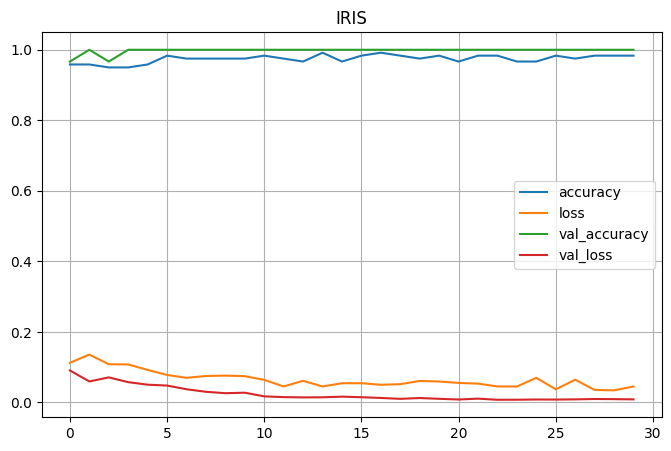

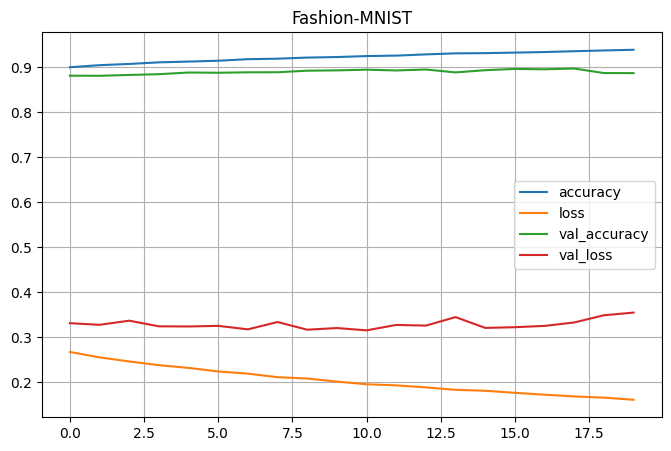

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history, title):
    # Convert to DataFrame
    df = pd.DataFrame(history.history)
    
    # Remove learning rate columns if present
    for col in ["lr", "learning_rate"]:
        if col in df.columns:
            df = df.drop(columns=[col])
    
    # Plot only the remaining metrics
    df.plot(figsize=(8, 5))
    plt.grid(True)
    plt.title(title)
    plt.show()

plot_history(history_iris, "IRIS")
plot_history(history_fmnist, "Fashion-MNIST")



In [7]:
# Save full models
best_model_iris.save("iris_full_model.keras")
best_model_fmnist.save("fmnist_full_model.keras")

# Save just weights
# Keras expects HDF5 weight filenames to end with ".weights.h5"
best_model_iris.save_weights("iris.weights.h5")
best_model_fmnist.save_weights("fmnist.weights.h5")

# Load models back
loaded_iris = keras.models.load_model("iris_full_model.keras")
loaded_fmnist = keras.models.load_model("fmnist_full_model.keras")

print("Models loaded successfully!")


Models loaded successfully!


##

## Regression Problem Assignment

1. Load the **California Housing** dataset and split it into training and testing sets.  
2. Build and train a neural network to predict housing prices. Tune hyperparameters and discuss the results.  
3. Plot the training history (loss over epochs, validation loss, etc.).  
4. Change the learning rate, retrain the network, plot the network history again, and discuss how the learning rate affected performance.  
5. Save the weights of the model’s layers and use callbacks during training.  
6. Practice saving and loading the trained model.

---

**Reference / Sample Code:**  
Neural networks with Keras — classification & regression examples:  
[10_neural_nets_with_keras.ipynb on GitHub](https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb)


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
housing = fetch_california_housing()
X = housing.data
y = housing.target

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((16512, 8), (4128, 8))

In [10]:
import keras_tuner as kt

def build_regression_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(X_train.shape[1],)))

    # Tune number of hidden layers
    for i in range(hp.Int("num_layers", 1, 4)):
        model.add(keras.layers.Dense(
            units=hp.Int(f"units_{i}", 32, 256, step=32),
            activation=hp.Choice("activation", ["relu", "tanh"])
        ))
        # Optional dropout
        if hp.Boolean(f"use_dropout_{i}"):
            model.add(keras.layers.Dropout(
                hp.Float(f"dropout_rate_{i}", 0.1, 0.5, step=0.1)
            ))

    # Output layer
    model.add(keras.layers.Dense(1))  # regression output

    # Tune learning rate
    lr = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=["mae"]
    )

    return model


In [11]:
tuner = kt.RandomSearch(
    build_regression_model,
    objective="val_loss",
    max_trials=10,
    directory="ca_housing_tuning",
    project_name="regression_tuning",
    overwrite=True
)

tuner.search(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3)
    ]
)


Trial 10 Complete [00h 00m 06s]
val_loss: 0.3823975920677185

Best val_loss So Far: 0.2892337441444397
Total elapsed time: 00h 01m 53s


In [12]:
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(1)[0]

best_hp.values


C:\Users\pablo\AppData\Roaming\Python\Python313\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


{'num_layers': 3,
 'units_0': 32,
 'activation': 'relu',
 'use_dropout_0': False,
 'learning_rate': 0.0034928656354620575,
 'units_1': 160,
 'use_dropout_1': True,
 'dropout_rate_1': 0.1,
 'units_2': 32,
 'use_dropout_2': False}

In [13]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("best_housing_model.keras", save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(patience=3)
]

history = best_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    callbacks=callbacks,
    batch_size=32
)


Epoch 1/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2775 - mae: 0.3611 - val_loss: 0.2779 - val_mae: 0.3543 - learning_rate: 0.0035
Epoch 2/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2771 - mae: 0.3601 - val_loss: 0.2864 - val_mae: 0.3660 - learning_rate: 0.0035
Epoch 3/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2700 - mae: 0.3546 - val_loss: 0.2841 - val_mae: 0.3704 - learning_rate: 0.0035
Epoch 4/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2644 - mae: 0.3518 - val_loss: 0.2808 - val_mae: 0.3681 - learning_rate: 0.0035
Epoch 5/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2467 - mae: 0.3385 - val_loss: 0.2603 - val_mae: 0.3454 - learning_rate: 3.4929e-04
Epoch 6/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2392 - mae: 0.3324 - val_loss: 0.2591 - val_mae: 0.3447 - learning_rate: 3.4929e-04
Epoch 7/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2377 - mae: 0.3310 - val_loss: 0.2575 - val_mae: 0.3424 - learning_rate: 3.492

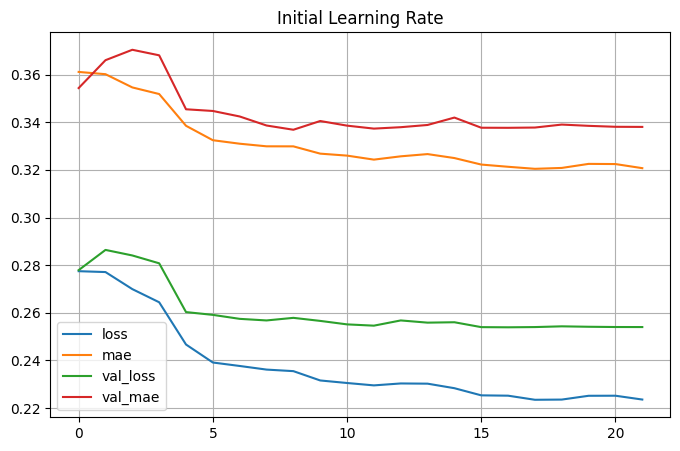

In [14]:

plot_history(history, "Initial Learning Rate")


In [15]:
model_lr = keras.Sequential([
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1)
])

model_lr.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.05),  # VERY HIGH LR
    loss="mse",
    metrics=["mae"]
)

history_lr = model_lr.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    callbacks=[keras.callbacks.EarlyStopping(patience=3)]
)


Epoch 1/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6178 - mae: 0.5329 - val_loss: 0.4325 - val_mae: 0.4612
Epoch 2/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3998 - mae: 0.4552 - val_loss: 0.3901 - val_mae: 0.4696
Epoch 3/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4299 - mae: 0.4692 - val_loss: 0.4429 - val_mae: 0.4959
Epoch 4/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3934 - mae: 0.4509 - val_loss: 0.3594 - val_mae: 0.4151
Epoch 5/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3911 - mae: 0.4461 - val_loss: 0.3595 - val_mae: 0.4288
Epoch 6/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3704 - mae: 0.4350 - val_loss: 0.3762 - val_mae: 0.4328
Epoch 7/40
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3747 - mae: 0.4377 - val_loss: 0.3909 - val_mae: 0.4457


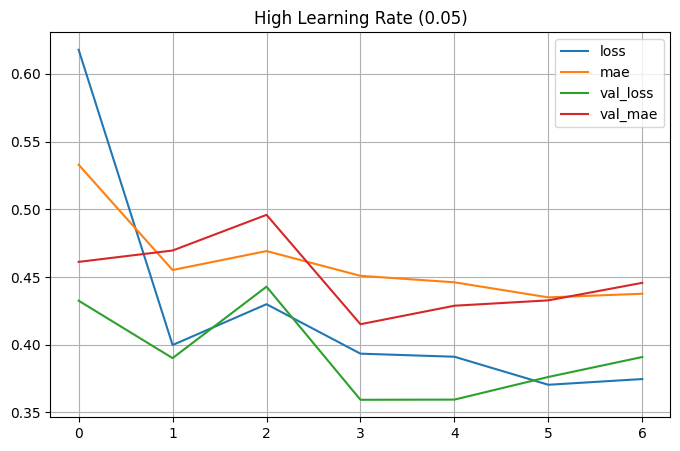

In [16]:
plot_history(history_lr, "High Learning Rate (0.05)")


In [18]:
# Keras expects HDF5 weight filenames to end with ".weights.h5"
best_model.save_weights("housing.weights.h5")


In [19]:
best_model.save("housing_full_model.keras")


In [20]:
loaded = keras.models.load_model("housing_full_model.keras")
loaded.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 160)            │         5,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,261 (126.02 KB)

 Trainable params: 10,753 (42.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,508 (84.02 KB)